# Proyek Klasifikasi Gambar: [Garbage Classification]
- **Nama:** [Muhammad Fadel Hamka]
- **Email:** [fadelhamka123@gmail.com]
- **ID Dicoding:** [Muhammad Fadel Hamka]

## Import Semua Packages/Library yang Digunakan

In [1]:
!pip install tensorflow
!pip install tensorflowjs
!pip install tf2onnx==1.14.0 --quiet
!pip install onnx==1.12.0 --quiet

import onnx
import os
import shutil
import time
import copy
import torch
import tensorflow as tf
import torch.nn as nn
import torch.optim as optim
import numpy as np
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import lr_scheduler
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 57.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires flatbuffers>=24.3.25, but you have flat

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Preparation

### Data Loading

In [3]:
# Paths
base_dir   = "/content/drive/MyDrive/Dataset Garbage/Garbage classification/Garbage classification"
split_root = "/content/garbage_split"

# Ambil daftar kelas
classes = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

classes

['paper', 'cardboard', 'glass', 'metal', 'plastic', 'trash']

### Data Preprocessing

#### Split Dataset

In [4]:
# Buat struktur folder train/val/test/<kelas>
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split_root, split, cls), exist_ok=True)

# Ambil semua path dan label
all_paths = []
all_labels = []
for cls in classes:
    for fname in glob(os.path.join(base_dir, cls, "*")):
        if fname.lower().endswith((".jpg", ".jpeg", ".png")):
            all_paths.append(fname)
            all_labels.append(cls)

In [5]:
# Stratified split
train_p, temp_p, train_l, temp_l = train_test_split(
    all_paths, all_labels, stratify=all_labels, test_size=0.30, random_state=42
)
val_p, test_p, val_l, test_l = train_test_split(
    temp_p, temp_l, stratify=temp_l, test_size=0.50, random_state=42
)

# Fungsi salin file
def copy_split(paths, labels, split_name):
    for src, lbl in zip(paths, labels):
        dst = os.path.join(split_root, split_name, lbl, os.path.basename(src))
        shutil.copy2(src, dst)

In [6]:
# Salin ke folder split
copy_split(train_p, train_l, "train")
copy_split(val_p, val_l, "val")
copy_split(test_p, test_l, "test")

In [7]:
# Hapus folder .ipynb_checkpoints jika terbentuk
for root, dirs, files in os.walk(split_root):
    if ".ipynb_checkpoints" in dirs:
        shutil.rmtree(os.path.join(root, ".ipynb_checkpoints"))

# Tampilkan jumlah file per kelas per split
print("=== File count per split ===\n")
for split in ["train", "val", "test"]:
    print(f"{split.upper()}:")
    total = 0
    for cls in classes:
        count = len(os.listdir(os.path.join(split_root, split, cls)))
        print(f"  {cls}: {count}")
        total += count
    print(f" Total {split}: {total}\n")

=== File count per split ===

TRAIN:
  paper: 416
  cardboard: 282
  glass: 350
  metal: 287
  plastic: 337
  trash: 96
 Total train: 1768

VAL:
  paper: 89
  cardboard: 61
  glass: 75
  metal: 61
  plastic: 72
  trash: 21
 Total val: 379

TEST:
  paper: 89
  cardboard: 60
  glass: 76
  metal: 62
  plastic: 73
  trash: 20
 Total test: 380



In [8]:
# Path ke split data
data_dir = "/content/garbage_split"

# Transformasi data
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [9]:
# Dataset dan DataLoader
batch_size = 32
dataloaders = {}
dataset_sizes = {}
for split in ['train', 'val', 'test']:
    folder = os.path.join(data_dir, split)
    ds = datasets.ImageFolder(folder, transform=data_transforms[split])
    dataloaders[split] = DataLoader(ds, batch_size=batch_size, shuffle=(split=='train'), num_workers=2)
    dataset_sizes[split] = len(ds)

class_names = dataloaders['train'].dataset.classes
num_classes = len(class_names)

# Gunakan GPU jika tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Modelling

In [10]:
# Load ResNet50 pretrained
num_classes = len(classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 103MB/s]


In [11]:
# Training
num_epochs = 20
best_acc = 0.0
train_loss_hist, val_loss_hist = [], []
train_acc_hist, val_acc_hist = [], []

start_time = time.time()
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print("-" * 20)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

        if phase == 'train':
            train_loss_hist.append(epoch_loss)
            train_acc_hist.append(epoch_acc.item())
        else:
            val_loss_hist.append(epoch_loss)
            val_acc_hist.append(epoch_acc.item())

        # Simpan model terbaik
        if phase == 'val' and epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), "best_resnet50.pth")

print(f"\nTraining selesai dalam {int(time.time() - start_time)} detik")
print(f"Akurasi terbaik validasi: {best_acc:.4f}")


Epoch 1/20
--------------------
Train Loss: 1.1677 Acc: 0.6012
Val Loss: 0.7467 Acc: 0.7995

Epoch 2/20
--------------------
Train Loss: 0.6939 Acc: 0.7562
Val Loss: 0.6825 Acc: 0.7467

Epoch 3/20
--------------------
Train Loss: 0.5957 Acc: 0.7936
Val Loss: 0.5710 Acc: 0.8074

Epoch 4/20
--------------------
Train Loss: 0.4924 Acc: 0.8422
Val Loss: 0.5138 Acc: 0.8522

Epoch 5/20
--------------------
Train Loss: 0.4651 Acc: 0.8456
Val Loss: 0.4731 Acc: 0.8443

Epoch 6/20
--------------------
Train Loss: 0.4210 Acc: 0.8558
Val Loss: 0.4909 Acc: 0.8285

Epoch 7/20
--------------------
Train Loss: 0.4044 Acc: 0.8609
Val Loss: 0.4576 Acc: 0.8391

Epoch 8/20
--------------------
Train Loss: 0.3893 Acc: 0.8773
Val Loss: 0.4481 Acc: 0.8549

Epoch 9/20
--------------------
Train Loss: 0.3771 Acc: 0.8654
Val Loss: 0.4407 Acc: 0.8443

Epoch 10/20
--------------------
Train Loss: 0.3560 Acc: 0.8727
Val Loss: 0.4279 Acc: 0.8575

Epoch 11/20
--------------------
Train Loss: 0.3362 Acc: 0.8778
Val 

## Evaluasi dan Visualisasi

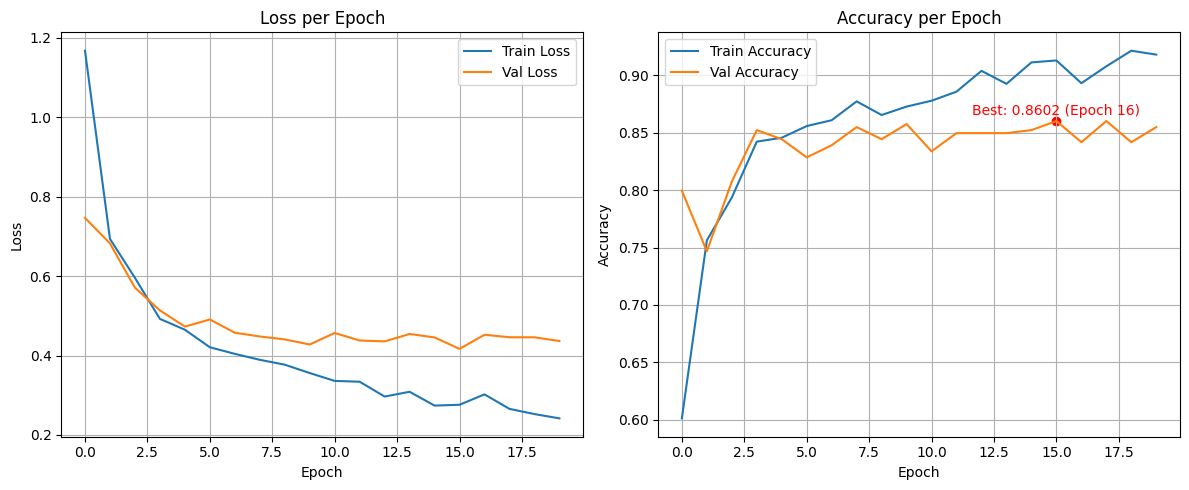

In [12]:
plt.figure(figsize=(12, 5))

# Grafik Loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_hist, label='Train Loss')
plt.plot(val_loss_hist, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

# Grafik Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_hist, label='Train Accuracy')
plt.plot(val_acc_hist, label='Val Accuracy')

# Tandai akurasi validasi terbaik
best_val_acc = max(val_acc_hist)
best_epoch = val_acc_hist.index(best_val_acc)
plt.scatter(best_epoch, best_val_acc, color='red')
plt.text(best_epoch, best_val_acc + 0.005,
         f'Best: {best_val_acc:.4f} (Epoch {best_epoch + 1})',
         color='red', ha='center')

plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

## Konversi Model

In [13]:
## === Simpan ke format SavedModel karena model terbaik sudah ada pada saat training ===

# Buat ulang model ResNet50
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 6)  # 6 kelas
model.load_state_dict(torch.load("best_resnet50.pth", map_location=torch.device('cpu')))
model.eval()

#  Export ke ONNX
dummy_input = torch.randn(1, 3, 224, 224)
torch.onnx.export(model, dummy_input, "resnet50.onnx",
                  input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=11)

# Konversi ke SavedModel
!rm -rf saved_model/
!python -m tf2onnx.convert \
    --input resnet50.onnx \
    --saved-model saved_model

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


2025-05-12 03:54:57.140118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747022097.218410   58741 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747022097.239338   58741 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
<frozen runpy>:128: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
usage: convert.py [-h] [--input INPUT] [--graphdef GRAPHDEF]
                  [--saved-model SAVED_MODEL] [--tag TAG]
                  [--signature_def SIGNATURE_DEF]
                  [--concrete_function CONCRETE_FUNCTION]
            

In [14]:
# Buat model kosong ResNet50 dengan jumlah kelas yang sesuai
NUM_CLASSES = 6  # paper, cardboard, glass, metal, plastic, trash

model_tf = tf.keras.applications.ResNet50(
    weights=None, input_shape=(224, 224, 3), classes=NUM_CLASSES
)


# Kompilasi model dummy (diperlukan agar model valid)
model_tf.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Simpan sebagai SavedModel (struktur folder lengkap)
tf.saved_model.save(model_tf, "saved_model")

In [21]:
## === Konversi ke TF-Lite ===

# 1. Load SavedModel dengan TFSMLayer
model = tf.keras.layers.TFSMLayer("saved_model", call_endpoint="serving_default")

# 2. Bungkus ke dalam tf.Module agar bisa dikonversi
class ModelWrapper(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model

    @tf.function(input_signature=[tf.TensorSpec(shape=[1, 224, 224, 3], dtype=tf.float32)])
    def __call__(self, x):
        return self.model(x)

wrapped_model = ModelWrapper(model)

# 3. Simpan ulang sebagai frozen SavedModel
tf.saved_model.save(wrapped_model, "saved_model_frozen")

# 4. Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model("saved_model_frozen")
tflite_model = converter.convert()

# 5. Simpan hasil konversi
with open("tflite/model.tflite", "wb") as f:
    f.write(tflite_model)

print("✅ Model berhasil dikonversi ke TFLite tanpa error READ_VARIABLE.")

✅ Model berhasil dikonversi ke TFLite tanpa error READ_VARIABLE.


In [16]:
## === Konversi ke TFJS ===
# 5.1 Bersihkan target
!rm -rf tfjs_model/ && mkdir tfjs_model

# 5.2 Konversi
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    saved_model \
    tfjs_model

2025-05-12 03:55:28.654949: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747022128.734352   58905 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747022128.754125   58905 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-12 03:55:40.951160: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1747022143.383992   58905 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

In [17]:
!mkdir -p submission/{saved_model,tfjs_model,tflite}
!cp -r saved_model/* submission/saved_model/
!cp -r tfjs_model/* submission/tfjs_model/
!cp -r tflite/* submission/tflite/

In [18]:
!pip freeze > requirements.txt

## Inference (Optional)

✅ Prediksi: paper (0.18)


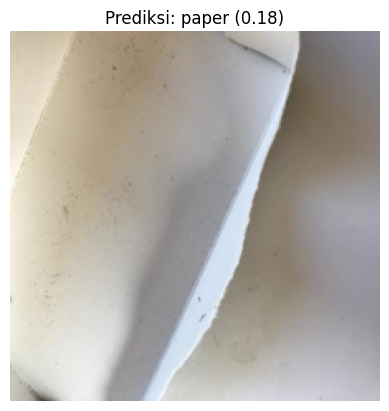

In [25]:
# 1. Load label
with open("tflite/label.txt", "r") as f:
    class_names = [line.strip() for line in f.readlines()]

# 2. Load TFLite model
interpreter = tf.lite.Interpreter(model_path="tflite/model.tflite")
interpreter.allocate_tensors()

# 3. Ambil info input/output
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# 4. Load dan preprocess gambar
image_path = "/content/garbage_split/test/paper/paper107.jpg"  # Ganti dengan path gambar uji kamu
image = Image.open(image_path).resize((224, 224)).convert("RGB")
input_data = np.expand_dims(np.array(image) / 255.0, axis=0).astype(np.float32)

# 5. Inference
interpreter.set_tensor(input_details[0]['index'], input_data)
interpreter.invoke()
output_data = interpreter.get_tensor(output_details[0]['index'])

# 6. Ambil hasil prediksi
predicted_class = np.argmax(output_data)
confidence = np.max(output_data)

# 7. Tampilkan hasil
print(f"✅ Prediksi: {class_names[predicted_class]} ({confidence:.2f})")

plt.imshow(image)
plt.title(f"Prediksi: {class_names[predicted_class]} ({confidence:.2f})")
plt.axis('off')
plt.show()